# Asynchronous Advantage Actor Critic
  
## Overview

In this tutorial we will see a few useful concepts:

- A3C, one of the simplest and most effective Deep RL techniques, which basically made DQN obsolete.
- Eager execution: operations are executed immediately as they are called from Python. This to make research and development more intuitive.
- Model subclassing: we will subclass tf.keras.Model and custumize our forward pass. Because of eager executing the forward pass can be written imperatively.

We will need to:

- Create a master agent supervisor
- Create worker agents
- Implement A3C
- Train 

Paper: Asynchronous Methods for Deep Reinforcement Learning by Volodymyr Mnih


# Task: CartPole



Cartpole is a simple game in which the player needs to balance pole connected to a cart with un-actuated joint. The cart can move left or right. At the beginning cart position, velocity, pole angle, and velocity are randomly initialized between +/-0.05.

The agent can apply a force of +1 or -1 to the cart which will move it left or right). The goals is to balance the pole acting on the cart.

At every timestep in which the pole is upright the agent receive a positive reward of +1. If the pole is more than 15 degrees from vertical or the cart moves more than 2.4 units from the center the episode ends.



## Actor critic model

### Policy gradients


The idea behind policy gradients is to parametrise the action probability distribution given some input state.in DL a network do the job: takes the state of the game (using raw pixels, RAM or others) output probability distributions. Then it will sample from the distributions and decides what we should do.

More formally, policy gradients are a special case of the more general score function gradient estimator. The general case is expressed in the form of Expectation(x | ) [f(x)]:the expectation of the reward function f, under the policy p.Using the log derivative trick, we demonstrate that we can search for our network’s parameters to find the action samples that maximises rewards, just like for normal Deep Learning problems: ∇ Ex[f(x)] = Ex[f(x) ∇ log p(x)]. This last equation is saying that bu moving θ in the direction of the gradient we can maximize the value of the expected reward function.

As we said the Value functions is telling us how good a certain state is, basically corresponds to the loss function of a supervised learning problem. The value function, the Critic part of the algorithm, is used by the agent uses This is where the “Critic” part of the name becomes relevant. The agent uses the value estimate (the critic) to update the policy (the actor).

Implementation
Let’s first define what kind of model we’ll be using. The master agent will have the global network and each local worker agent will have a copy of this network in their own process. We will instantiate the model using Kera's model class, which can be find in tensorflow.



In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import threading
import gym
import multiprocessing
import numpy as np
from queue import Queue
import argparse
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

tf.enable_eager_execution()

verbose = False

class ActorCriticModel(keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.dense1 = layers.Dense(100, activation='relu') 
        self.policy_logits = layers.Dense(action_size)
        self.dense2 = layers.Dense(100, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        # Forward pass
        x = 0 # Complete here
        logits = 0 # Complete here
        v1 = 0 # Complete here
        values = 0 # Complete here
        return logits, values



## Random Agent 


To have a baseline we will create a random agent.

In [2]:
class RandomAgent(object):
    """
      env_name: OpenAi-s gym enviroment name.
      max_eps: Maximum number of episodes the agent will run.
    """

    def __init__(self, env_name, max_eps):
        self.env = gym.make(env_name)
        self.max_episodes = max_eps
        self.global_moving_average_reward = 0
        self.res_queue = Queue()

    def run(self):
        reward_avg = 0
        for episode in range(self.max_episodes):

            done = False
            self.env.reset()
            reward_sum = 0.0
            steps = 0
            while not done:
                # Sample randomly from the action space and step
                _, reward, done, _ = self.env.step()  # Complete here
                steps += 1
                reward_sum += reward
                # Record statistics
                self.global_moving_average_reward = record(
                    episode, reward_sum, 0, self.global_moving_average_reward,
                    self.res_queue, 0, steps)

                reward_avg += reward_sum

        final_avg = reward_avg / float(self.max_episodes)
        print("Average score across {} episodes: {}".format(
            self.max_episodes, final_avg))
        return final_avg


def record(episode, episode_reward, worker_idx, global_ep_reward, result_queue,
           total_loss, num_steps):
    """Store score  statistics.
    """
    if global_ep_reward == 0:
        global_ep_reward = episode_reward
    else:
        global_ep_reward = global_ep_reward * 0.99 + episode_reward * 0.01
        if verbose:
            print(f"Episode: {episode}:  "
                  f"Episode Reward: {int(episode_reward)}:  "
                  f"Steps: {num_steps}:  "
                  f"Worker: {worker_idx}: ")
    result_queue.put(global_ep_reward)
    return global_ep_reward



## Master Agent 

The master agent is responsible to keep a shared optimizer that updates its global network. Each worker agent will update both the global network and hte optimiser. Ee’ll use the AdamOptimizer with a very small learning rate for the CartPole task.

One of the disadvantages of A3C is that some agents might end up working with an outdated version of the network, but that is not a huge problem.

The master agent will run the train function to instantiate and start each of the agents. The master agent handles the coordinating and supervision of each agent. Each of these agents will run asynchronously. The workers will be implemented with a threads to make it more easy to understan.. Let's pretend GIL is not a think in Python (Global Interpreter Lock: a single python process can't run threads in parallel and can't use multiple cores). But it can run them concurrently during I/O bound operations. 

We will also create a "play" method to allow us to use a trained instance,



In [1]:
class MasterAgent(object):
    def __init__(self,
                 env_name='CartPole-v0',
                 save_dir='.',
                 algorithm='A3C',
                 lr=0.0001,
                 max_eps=100):
        self.game_name = env_name
        self.save_dir = save_dir
        self.algorithm = algorithm
        self.max_eps = max_eps

        env = gym.make(self.game_name)
        self.state_size = 0 # Complete here
        self.action_size = 0 # Complete here
        self.opt = 0 # Complete here
        print(self.state_size, self.action_size)

        self.global_model = ActorCriticModel(
            self.state_size, self.action_size)  # global network
        self.global_model(
            tf.convert_to_tensor(
                np.random.random((1, self.state_size)), dtype=tf.float32))

    def train(self):
        if self.algorithm == 'random':
            random_agent = RandomAgent(self.game_name, self.max_eps)
            random_agent.run()
            return

        res_queue = Queue()

        workers = [
            Worker(
                self.state_size,
                self.action_size,
                self.global_model,
                self.opt,
                res_queue,
                i,
                game_name=self.game_name,
                save_dir=self.save_dir,
                max_eps=self.max_eps)
            for i in range(multiprocessing.cpu_count())
        ]

        for i, worker in enumerate(workers):
            print("Starting worker {}".format(i))
            worker.start()

        moving_average_rewards = []  # record episode reward to plot
        while True:
            reward = res_queue.get()
            if reward is not None:
                moving_average_rewards.append(reward)
            else:
                break
        [w.join() for w in workers]

        plt.plot(moving_average_rewards)
        plt.ylabel('Moving avg episode reward')
        plt.xlabel('Step')
        plt.show()
        
        
    def play(self):
        env = gym.make(self.game_name).unwrapped
        state = env.reset()
        model = self.global_model
        model_path = os.path.join(self.save_dir,
                                  'model_{}.h5'.format(self.game_name))
        print('Loading model {}'.format(model_path))
        model.load_weights(model_path)
        done = False
        step_counter = 0
        reward_sum = 0

        while not done:
            env.render(mode='rgb_array')
            policy, value = model(
                tf.convert_to_tensor(state[None, :], dtype=tf.float32))
            policy = tf.nn.softmax(policy)
            action = np.argmax(policy)
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            print("{}. Reward: {}, action: {}".format(
                step_counter, reward_sum, action))
            step_counter += 1

        env.close()

## Memory
To keep track of the hsitory, we’ll implement a Memory class. We want tokeep track of our actions, rewards, states of each step.

In [4]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def store(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []


## Worker Agent

The most important part of the algorithm is the worker agent. To be asynchronous the worker agent inherits from the threading class, and we override the run method from Thread.



### Running the algorithm

We’ll run all the threads for a set maximum number of episodes. This is where the third Actor part happens. Our agent will “act” according to our policy function, becoming the actor while the action is judged by the “critic,” which is our value function.

this might seem complicated but all it only does:

- Get the action probability distribution based on the current frame
- Act according to policy

The the agent will update the global model with the local gradient when the agent has taken the set number of steps (args.update_freq) or the agent has died then. 

After this it will all start again. The worker agent will repeat the process of resetting the network parameters to all of those in the global network, and repeating the process of interacting with its environment, computing the loss, and then applying the gradients to the global network. 


## Computing the losses

The worker agent calculates the losses to obtain gradients with respect to all of its own network parameters. This is where the last A of A3C come into play, the advantage. These are then applied to the global network. The losses are calculated as:

- Value Loss: L=∑(R — V(s))²
- Policy Loss: L = -log(𝝅(s)) * A(s)

Where R is the discounted rewards, V our value function (of an input state), 𝛑 our policy function (of an input state as well), and A our advantage function. We use the discounted rewards to estimate our Q value since we don’t directly determine the Q value with A3C.




In [5]:
class Worker(threading.Thread):
    # Set up global variables across different threads
    global_episode = 0
    # Moving average reward
    global_moving_average_reward = 0
    best_score = 0
    save_lock = threading.Lock()

    def __init__(self,
                 state_size,
                 action_size,
                 global_model,
                 opt,
                 result_queue,
                 idx,
                 max_eps=500,
                 game_name='CartPole-v0',
                 save_dir='/tmp',
                 update_freq=20,
                 gamma=0.99):
        super(Worker, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.result_queue = result_queue
        self.global_model = global_model
        self.opt = opt
        self.local_model = ActorCriticModel(self.state_size, self.action_size)
        self.worker_idx = idx
        self.max_eps = max_eps
        self.game_name = game_name
        self.env = gym.make(self.game_name).unwrapped
        self.save_dir = save_dir
        self.update_freq = update_freq
        self.gamma = gamma
        self.ep_loss = 0.0

    def run(self):
        total_step = 1
        mem = Memory()
        while Worker.global_episode < self.max_eps:
            current_state = self.env.reset()
            mem.clear()
            ep_reward = 0.
            ep_steps = 0
            self.ep_loss = 0

            time_count = 0
            done = False
            while not done:
                logits, _ = self.local_model(
                    tf.convert_to_tensor(
                        current_state[None, :], dtype=tf.float32))
                probs = tf.nn.softmax(logits)

                action = np.random.choice(self.action_size, p=probs.numpy()[0])
                new_state, reward, done, _ = self.env.step(action)
                if done:
                    reward = -1
                ep_reward += reward
                mem.store(current_state, action, reward)

                if time_count == self.update_freq or done:
                    # Calculate gradient wrt to local model. We do so by tracking the
                    # variables involved in computing the loss by using tf.GradientTape
                    with tf.GradientTape() as tape:
                        total_loss = self.compute_loss(done, new_state, mem,
                                                       self.gamma)
                    self.ep_loss += total_loss
                    # Calculate local gradients
                    grads = tape.gradient(total_loss,
                                          self.local_model.trainable_weights)
                    # Push local gradients to global model
                    self.opt.apply_gradients(
                        zip(grads, self.global_model.trainable_weights))
                    # Update local model with new weights
                    self.local_model.set_weights(
                        self.global_model.get_weights())

                    mem.clear()
                    time_count = 0

                    if done:  # done and print information
                        Worker.global_moving_average_reward = \
                          record(Worker.global_episode, ep_reward, self.worker_idx,
                                 Worker.global_moving_average_reward, self.result_queue,
                                 self.ep_loss, ep_steps)
                        # We must use a lock to save our model and to print to prevent data races.
                        if ep_reward > Worker.best_score:
                            with Worker.save_lock:
                                print("Saving best model to {}, "
                                      "episode score: {}".format(
                                          self.save_dir, ep_reward))
                                self.global_model.save_weights(
                                    os.path.join(
                                        self.save_dir,
                                        'model_{}.h5'.format(self.game_name)))
                                Worker.best_score = ep_reward
                        Worker.global_episode += 1
                ep_steps += 1

                time_count += 1
                current_state = new_state
                total_step += 1
        self.result_queue.put(None)

    def compute_loss(self, done, new_state, memory, gamma=0.99):
        if done:
            reward_sum = 0.  # terminal
        else:
            reward_sum = self.local_model(
                tf.convert_to_tensor(new_state[None, :],
                                     dtype=tf.float32))[-1].numpy()[0]

        # Get discounted rewards
        discounted_rewards = []
        for reward in memory.rewards[::-1]:  # reverse buffer r
            reward_sum = 0 # Complete here
            discounted_rewards.append(reward_sum)
        discounted_rewards.reverse()

        logits, values = self.local_model(
            tf.convert_to_tensor(np.vstack(memory.states), dtype=tf.float32))
        # Get our advantages
        advantage = tf.convert_to_tensor(
            np.array(discounted_rewards)[:, None], dtype=tf.float32) - values
        # Value loss
        value_loss = advantage**2

        # Calculate our policy loss
        policy = 0 # Complete here
        entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=policy, logits=logits)

        policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=memory.actions, logits=logits)
        policy_loss *= tf.stop_gradient(advantage)
        policy_loss -= 0.01 * entropy
        total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
        return total_loss

# Training A3C

4 2
Starting worker 0
Starting worker 1
Starting worker 2
Starting worker 3
Starting worker 4
Starting worker 5
Starting worker 6
Starting worker 7
Instructions for updating:
Colocations handled automatically by placer.
Saving best model to ., episode score: 15.0
Saving best model to ., episode score: 16.0
Saving best model to ., episode score: 10.0
Saving best model to ., episode score: 11.0
Saving best model to ., episode score: 14.0
Saving best model to ., episode score: 13.0
Saving best model to ., episode score: 12.0
Saving best model to ., episode score: 34.0
Saving best model to ., episode score: 48.0
Saving best model to ., episode score: 51.0
Saving best model to ., episode score: 86.0
Saving best model to ., episode score: 118.0


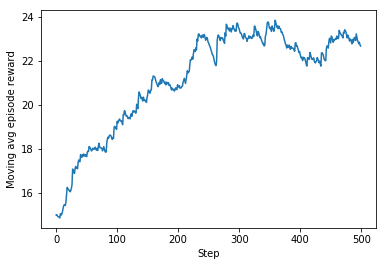

In [6]:
master = MasterAgent(max_eps=500)
master.train()

# Playing with the trained model

In [7]:
master.play()

Loading model ./model_CartPole-v0.h5
0. Reward: 1.0, action: 0
1. Reward: 2.0, action: 1
2. Reward: 3.0, action: 0
3. Reward: 4.0, action: 1
4. Reward: 5.0, action: 0
5. Reward: 6.0, action: 1
6. Reward: 7.0, action: 0
7. Reward: 8.0, action: 1
8. Reward: 9.0, action: 0
9. Reward: 10.0, action: 1
10. Reward: 11.0, action: 0
11. Reward: 12.0, action: 1
12. Reward: 13.0, action: 0
13. Reward: 14.0, action: 1
14. Reward: 15.0, action: 0
15. Reward: 16.0, action: 1
16. Reward: 17.0, action: 0
17. Reward: 18.0, action: 1
18. Reward: 19.0, action: 0
19. Reward: 20.0, action: 1
20. Reward: 21.0, action: 0
21. Reward: 22.0, action: 1
22. Reward: 23.0, action: 0
23. Reward: 24.0, action: 1
24. Reward: 25.0, action: 0
25. Reward: 26.0, action: 1
26. Reward: 27.0, action: 0
27. Reward: 28.0, action: 1
28. Reward: 29.0, action: 0
29. Reward: 30.0, action: 0
30. Reward: 31.0, action: 1
31. Reward: 32.0, action: 0
32. Reward: 33.0, action: 1
33. Reward: 34.0, action: 0
34. Reward: 35.0, action: 1
35

282. Reward: 283.0, action: 1
283. Reward: 284.0, action: 0
284. Reward: 285.0, action: 1
285. Reward: 286.0, action: 1
286. Reward: 287.0, action: 0
287. Reward: 288.0, action: 1
288. Reward: 289.0, action: 0
289. Reward: 290.0, action: 1
290. Reward: 291.0, action: 0
291. Reward: 292.0, action: 1
292. Reward: 293.0, action: 1
293. Reward: 294.0, action: 0
294. Reward: 295.0, action: 1
295. Reward: 296.0, action: 0
296. Reward: 297.0, action: 1
297. Reward: 298.0, action: 0
298. Reward: 299.0, action: 1
299. Reward: 300.0, action: 0
300. Reward: 301.0, action: 1
301. Reward: 302.0, action: 1
302. Reward: 303.0, action: 0
303. Reward: 304.0, action: 1
304. Reward: 305.0, action: 0
305. Reward: 306.0, action: 1
306. Reward: 307.0, action: 0
307. Reward: 308.0, action: 1
308. Reward: 309.0, action: 0
309. Reward: 310.0, action: 0
310. Reward: 311.0, action: 1
311. Reward: 312.0, action: 0
312. Reward: 313.0, action: 1
313. Reward: 314.0, action: 0
314. Reward: 315.0, action: 1
315. Rewar

563. Reward: 564.0, action: 0
564. Reward: 565.0, action: 0
565. Reward: 566.0, action: 0
566. Reward: 567.0, action: 1
567. Reward: 568.0, action: 0
568. Reward: 569.0, action: 1
569. Reward: 570.0, action: 0
570. Reward: 571.0, action: 1
571. Reward: 572.0, action: 0
572. Reward: 573.0, action: 1
573. Reward: 574.0, action: 0
574. Reward: 575.0, action: 1
575. Reward: 576.0, action: 1
576. Reward: 577.0, action: 1
577. Reward: 578.0, action: 0
578. Reward: 579.0, action: 1
579. Reward: 580.0, action: 1
580. Reward: 581.0, action: 0
581. Reward: 582.0, action: 1
582. Reward: 583.0, action: 0
583. Reward: 584.0, action: 1
584. Reward: 585.0, action: 0
585. Reward: 586.0, action: 1
586. Reward: 587.0, action: 0
587. Reward: 588.0, action: 1
588. Reward: 589.0, action: 0
589. Reward: 590.0, action: 1
590. Reward: 591.0, action: 0
591. Reward: 592.0, action: 0
592. Reward: 593.0, action: 1
593. Reward: 594.0, action: 0
594. Reward: 595.0, action: 1
595. Reward: 596.0, action: 0
596. Rewar

867. Reward: 868.0, action: 0
868. Reward: 869.0, action: 1
869. Reward: 870.0, action: 0
870. Reward: 871.0, action: 0
871. Reward: 872.0, action: 0
872. Reward: 873.0, action: 1
873. Reward: 874.0, action: 0
874. Reward: 875.0, action: 1
875. Reward: 876.0, action: 0
876. Reward: 877.0, action: 0
877. Reward: 878.0, action: 1
878. Reward: 879.0, action: 0
879. Reward: 880.0, action: 1
880. Reward: 881.0, action: 0
881. Reward: 882.0, action: 1
882. Reward: 883.0, action: 0
883. Reward: 884.0, action: 1
884. Reward: 885.0, action: 1
885. Reward: 886.0, action: 1
886. Reward: 887.0, action: 1
887. Reward: 888.0, action: 1
888. Reward: 889.0, action: 0
889. Reward: 890.0, action: 1
890. Reward: 891.0, action: 1
891. Reward: 892.0, action: 0
892. Reward: 893.0, action: 1
893. Reward: 894.0, action: 0
894. Reward: 895.0, action: 1
895. Reward: 896.0, action: 0
896. Reward: 897.0, action: 1
897. Reward: 898.0, action: 0
898. Reward: 899.0, action: 1
899. Reward: 900.0, action: 0
900. Rewar

KeyboardInterrupt: 